# 3. Luminosity function

In [1]:
import pathlib

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import config
import utils

hpx_order=7 --> (hpx_nside=128, hpx_npix=196608)
model_hpx_order=5 --> (model_hpx_nside=32, model_hpx_npix=12288)


In [2]:
cache_path = pathlib.Path(config.cache_path)
cache_path.mkdir(exist_ok=True)

fig_path = pathlib.Path(config.fig_path)
fig_path.mkdir(exist_ok=True)

## Load extinction maps

In [3]:
res = np.load(cache_path / 'am_map.npz')
ag_map  = res['ag_map']
abp_map = res['abp_map']
arp_map = res['arp_map']
print("shape(AG_map) =", ag_map.shape)

print("min(ag),  max(ag)  =", np.nanmin(ag_map), np.nanmax(ag_map))
print("min(abp), max(abp) =", np.nanmin(abp_map), np.nanmax(abp_map))
print("min(arp), max(arp) =", np.nanmin(arp_map), np.nanmax(arp_map))

shape(AG_map) = (196608,)
min(ag),  max(ag)  = 0.0002497657 13.639912
min(abp), max(abp) = 0.00031270608 19.255543
min(arp), max(arp) = 0.00019200039 12.222513


In [54]:
res = np.load(cache_path / 's4_am_map.npz')
AG_map  = res['AG_map']
ABP_map = res['ABP_map']
ARP_map = res['ARP_map']
print("shape(AG_map) =", AG_map.shape)

shape(AG_map) = (196608,)


In [4]:
# Later we will join this table with the globular cluster stars catalogue by the `hpx' key
am = pd.DataFrame({'hpx': np.arange(config.hpx_npix),
                   'ag': ag_map, 'abp': abp_map, 'arp': arp_map})

## Load a donor globular cluster from catalogue of Vasiliev & Baumgardt (2021)

Paper: https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.5978V

Data: https://doi.org/10.5281/zenodo.4891252

In [5]:
class Struct():  pass

gc = Struct()
gc.name = 'NGC_6397'
gc.path = cache_path / 'Vasiliev2021_clusters/catalogues' / (gc.name + '.txt')
gc.path

PosixPath('cache/Vasiliev2021_clusters/catalogues/NGC_6397.txt')

In [6]:
gc.all_stars = pd.read_csv(gc.path, delimiter='\s+', comment='#',
                           names=['source_id', 'ra', 'dec', 'x', 'y', 'plx', 'pmra', 'pmdec', 'plxe', 'pmrae', 'pmdece', 'pmcorr',
                                  'g_mag', 'bp_rp', 'Sigma', 'qflag', 'memberprob'],
                           dtype={'source_id': int, 'qflag': int})

In [7]:
# Filter stars by a membership probability
num_stars0 = len(gc.all_stars)
mask = gc.all_stars['memberprob'] > 0.9
#mask &= gc.all_stars['qflag'] == 3
gc.all_stars = gc.all_stars[mask].copy()
print(f"{gc.name}:\t{num_stars0} -> {len(gc.all_stars)}")

NGC_6397:	103786 -> 35247


In [8]:
# Drop redundant columns
gc.all_stars.drop(['pmra', 'pmdec', 'plxe', 'pmrae', 'pmdece', 'pmcorr', 'Sigma', 'qflag', 'memberprob'], axis='columns', inplace=True, errors='ignore')
gc.all_stars

,source_id,ra,dec,x,y,plx,g_mag,bp_rp
69,5921764499563561088,264.513253,-53.554013,-0.3933,0.1185,0.5506,17.7529,1.0021
93,5921764469498842240,264.535738,-53.547454,-0.3800,0.1252,0.0434,19.1133,1.2285
156,5921764297708548736,264.522510,-53.574337,-0.3877,0.0982,1.1069,20.3081,1.4496
218,5921794186381089408,264.891456,-53.305860,-0.1697,0.3681,0.5547,18.2711,1.1003
249,5921794534294318336,264.918563,-53.302982,-0.1535,0.3711,0.3162,20.8392,NaN
...,...,...,...,...,...,...,...,...
103527,5921697330585673984,265.718705,-53.888273,0.3202,-0.2152,-2.5101,20.6371,1.6382
103682,5921697708536850816,265.784107,-53.859293,0.3590,-0.1865,-0.0232,19.6320,1.4871
103738,5921691283265597696,265.711831,-53.935925,0.3158,-0.2628,-0.5960,20.1450,2.1770
103767,5921692039179832192,265.703675,-53.941228,0.3110,-0.2680,0.8761,20.1284,1.6229


## Load the combined catalogue by Baumgardt et al. (2023)

Paper: https://academic.oup.com/mnras/article/521/3/3991/7067267

Data: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/

Data for masses and structural parameters: https://people.smp.uq.edu.au/HolgerBaumgardt/globular/parameter.html

In [9]:
url = 'https://people.smp.uq.edu.au/HolgerBaumgardt/globular/combined_table.txt'
file_name = cache_path / 'Baumgardt2023_combined_table.txt'
utils.download_file(url, file_name)

baum = pd.read_table(file_name, skiprows=3, delimiter='\s+', header=None,
                     names=['name', 'ra', 'dec', 'D', 'sigma_D', 'D_GC', 'sigma_D_GC', 'N_RV', 'N_PM', 'Mass', 'sigma_Mass',
                            'V', 'sigma_V', 'M/L_V', 'sigma_(M_L_V)', 'r_c', 'r_hl', 'r_hm', 'r_t'],
                     usecols=np.arange(19), dtype={'name': str})

Starting download from https://people.smp.uq.edu.au/HolgerBaumgardt/globular/combined_table.txt
File 'cache/Baumgardt2023_combined_table.txt' already downloaded
Done


In [10]:
# Find the GC in the Baumgardt catalogue
mask = baum['name'] == gc.name
if np.all(mask == False):
    raise ValueError(f"No '{gc.name}' in the catalogue")
gc.__dict__.update(baum[mask].iloc[0,1:].to_dict())

## Correct magnitude and colors for extinction

In [12]:
# Join the stars with their extinctions
gc.all_stars['hpx'] = gc.all_stars['source_id'] // config.hpx_base
gc.all_stars = gc.all_stars.merge(am, on='hpx')
gc.all_stars

,source_id,ra,dec,x,y,plx,g_mag,bp_rp,hpx,ag,abp,arp
0,5921764499563561088,264.513253,-53.554013,-0.3933,0.1185,0.5506,17.7529,1.0021,168306,0.665446,0.848013,0.523519
1,5921764469498842240,264.535738,-53.547454,-0.3800,0.1252,0.0434,19.1133,1.2285,168306,0.665446,0.848013,0.523519
2,5921764297708548736,264.522510,-53.574337,-0.3877,0.0982,1.1069,20.3081,1.4496,168306,0.665446,0.848013,0.523519
3,5921794186381089408,264.891456,-53.305860,-0.1697,0.3681,0.5547,18.2711,1.1003,168307,0.744918,0.951304,0.587632
4,5921794534294318336,264.918563,-53.302982,-0.1535,0.3711,0.3162,20.8392,NaN,168307,0.744918,0.951304,0.587632
...,...,...,...,...,...,...,...,...,...,...,...,...
35242,5921697330585673984,265.718705,-53.888273,0.3202,-0.2152,-2.5101,20.6371,1.6382,168304,0.567527,0.721341,0.444988
35243,5921697708536850816,265.784107,-53.859293,0.3590,-0.1865,-0.0232,19.6320,1.4871,168304,0.567527,0.721341,0.444988
35244,5921691283265597696,265.711831,-53.935925,0.3158,-0.2628,-0.5960,20.1450,2.1770,168304,0.567527,0.721341,0.444988
35245,5921692039179832192,265.703675,-53.941228,0.3110,-0.2680,0.8761,20.1284,1.6229,168304,0.567527,0.721341,0.444988


In [14]:
# Correct magnitudes
gc.all_stars['mg'] = gc.all_stars['g_mag'] - gc.all_stars['ag'] - 5*np.log10(gc.D) - 10
gc.all_stars['cg'] = gc.all_stars['bp_rp'] - (gc.all_stars['abp'] - gc.all_stars['arp'])

# Estimate the magnitude in V band
# https://gea.esac.esa.int/archive/documentation/GEDR3/Data_processing/chap_cu5pho/cu5pho_sec_photSystem/cu5pho_ssec_photRelations.html
gc.all_stars['v_mag'] = gc.all_stars['g_mag'] \
        - ( -0.02704 + 0.01424*gc.all_stars['cg'] - 0.2156*gc.all_stars['cg']**2 + 0.01426*gc.all_stars['cg']**3 )
gc.all_stars['av'] = 0.56
gc.all_stars['mv'] = gc.all_stars['v_mag'] - gc.all_stars['av'] - 5*np.log10(gc.D) - 10

gc.all_stars[['g_mag', 'mg', 'cg', 'v_mag', 'mv']].describe()

,g_mag,mg,cg,v_mag,mv
count,35247.000000,35247.000000,29664.000000,29664.000000,29664.000000
mean,18.686811,6.059529,0.879077,18.778669,6.246410
std,1.516657,1.519804,0.298333,1.633610,1.633610
min,9.366100,-3.271604,-1.586693,9.784147,-2.748112
25%,17.732100,5.101246,0.654468,17.714421,5.182163
50%,18.871500,6.243596,0.838507,18.918976,6.386718
75%,19.918000,7.293696,1.072412,20.129808,7.597549
max,20.977500,8.385815,4.386647,23.690796,11.158537


# Estimate radial profile

In [15]:
# Luminosity [L_sun]
gc.all_stars['L_V'] = 10**(0.4*(4.83 - gc.all_stars['mv']))

In [16]:
# Angular distance [arcmin]
gc.all_stars['r'] = gc.D*1e3 * np.sqrt(gc.all_stars['x']**2 + gc.all_stars['y']**2) * np.pi/180

### Process all stars

In [17]:
# Make subsamples in radial shells
r_min = gc.r_hm
r_max = gc.all_stars['r'].max()
r_edges = [ r_min, r_min + 0.33*(r_max - r_min), r_max ]
shells = []
for i in range(len(r_edges)-1):
    mask = (gc.all_stars['r'] >= r_edges[i]) & (gc.all_stars['r'] < r_edges[i+1])
    shells.append(gc.all_stars[mask].copy())

In [18]:
# Count luminosity function
mg_edges = np.linspace(-8.0, 10.0, 19)
lf_shells = []
L_shells = []
LM_Mass_shells = []
for i in range(len(r_edges)-1):
    hist, _ = np.histogram(shells[i]['mg'], bins=mg_edges)
    lf_shells.append(hist.astype(float))
    L_shells.append(shells[i]['L_V'].sum())
    LM_Mass_shells.append(L_shells[-1] * gc.__dict__['M/L_V'])

### Process RGB stars

In [19]:
# Select
mask = (gc.all_stars['cg'] > 0.75) & (gc.all_stars['mg'] < 3.0)
gc.rgb_stars = gc.all_stars[mask].copy()

In [20]:
# Make subsamples in radial shells
r_min = gc.r_hm
r_max = gc.rgb_stars['r'].max()
r_edges = [ r_min, r_min + 0.33*(r_max - r_min), r_max ]
rgb_shells = []
for i in range(len(r_edges)-1):
    mask = (gc.rgb_stars['r'] >= r_edges[i]) & (gc.rgb_stars['r'] < r_edges[i+1])
    rgb_shells.append(gc.rgb_stars[mask].copy())

In [21]:
# Count luminosity function
rgb_mg_edges = np.linspace(-8.0, 3.0, 12)
rgb_lf_shells = []
rgb_L_shells = []
for i in range(len(r_edges)-1):
    hist, _ = np.histogram(rgb_shells[i]['mg'], bins=rgb_mg_edges)
    rgb_lf_shells.append(hist.astype(float))
    rgb_L_shells.append(rgb_shells[i]['L_V'].sum())

### Done

In [22]:
gc.r_edges = r_edges
#
gc.shells = shells
gc.mg_edges = mg_edges
gc.lf_shells = lf_shells
gc.L_shells = L_shells
gc.LM_Mass_shells = LM_Mass_shells
#
gc.rgb_shells = rgb_shells
gc.rgb_mg_edges = rgb_mg_edges
gc.rgb_lf_shells = rgb_lf_shells
gc.rgb_L_shells = rgb_L_shells

## Plot

18.032959432240766
18.032959432240766
16.564074219077895
16.564074219077895


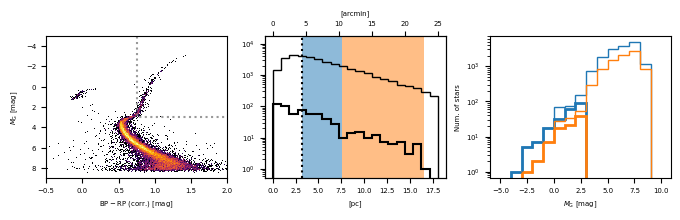

In [23]:
plt.rc('font', size=5.0)
inch = 2.54  ## cm
#width, height = 17/inch, 5.69/inch
width, height = 17/inch, 5.3/inch
plt.figure(figsize=(width, height), layout='constrained')
#plt.suptitle(f"{gc.name} | D={gc.D:.3g} kpc")

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


plt.subplot(1, 3, 1)
#
stars_ = gc.all_stars.dropna()
plt.hist2d(stars_['cg'], stars_['mg'], bins=200, range=((-0.5, 2.0), (-5.0, 9.0)), norm='log', cmap='inferno', rasterized=True)
#plt.plot(gc.all_stars['cg'], gc.stars['mg'], '.')
##plt.plot([2.0, 0.75, 1.0, 2.0], [3.0, 3.0, -3.5, -3.5], c='k', ls=':')
plt.plot([5.0, 0.75, 0.75, 5.0], [3.0, 3.0, -8.0, -8.0], c='grey', alpha=0.8, ls=':')
#
plt.xlabel(r"$\mathrm{BP} - \mathrm{RP}$ (corr.) [mag]")
plt.xlim(-0.5, 2.0)
plt.ylabel(r"$M_\mathrm{G}$ [mag]")
plt.ylim(9.0, -5.0)
#plt.ylim(gc.all_stars['mg'].max(), gc.all_stars['mg'].min())


plt.subplot(1, 3, 2)
#
rect = mpl.patches.Rectangle((gc.r_edges[0], 0.0), (gc.r_edges[1] - gc.r_edges[0]), 1e6,
                             facecolor=colors[0], edgecolor='None', alpha=0.5)
plt.gca().add_patch(rect)
rect = mpl.patches.Rectangle((gc.r_edges[1], 0.0), (gc.r_edges[2] - gc.r_edges[1]), 1e6,
                             facecolor=colors[1], edgecolor='None', alpha=0.5)
plt.gca().add_patch(rect)
#
hist, r_edges = np.histogram(gc.all_stars['r'], bins=20)
print(max(gc.all_stars['r']))
print(max(r_edges))
print(max(gc.rgb_stars['r']))
print(gc.r_edges[-1])
plt.stairs(hist, r_edges, color='k', lw=1)
#
hist, _ = np.histogram(gc.rgb_stars['r'], bins=r_edges)
plt.stairs(hist, r_edges, color='k', lw=1.5)
#
plt.axvline(gc.r_edges[0], c='k', ls=':')
#plt.axvline(gc.r_edges[1], c='k', ls=':')
#plt.axvline(gc.r_edges[2], c='k', ls=':')
#
plt.xlabel("[pc]")
ax1 = plt.gca()
ax2 = ax1.twiny()
ax2.set_xlabel("[arcmin]")
xlim = ax1.get_xlim()
ax2.set_xlim([xlim[0]*1e-3/gc.D * 180*60/np.pi, xlim[1]*1e-3/gc.D * 180*60/np.pi])
plt.ylabel("Num. of stars")
plt.yscale('log')
plt.ylim(ymax=0.5*len(gc.all_stars))


plt.subplot(1, 3, 3)
#
p_1 = plt.stairs(gc.rgb_lf_shells[0], gc.rgb_mg_edges, ec=colors[0], lw=2, label="inner")
p_2 = plt.stairs(gc.rgb_lf_shells[1], gc.rgb_mg_edges, ec=colors[1], lw=2, label="outer")
#
plt.stairs(gc.lf_shells[0], gc.mg_edges, ec=colors[0], lw=1)
plt.stairs(gc.lf_shells[1], gc.mg_edges, ec=colors[1], lw=1)
#
#plt.axvline(2.7, ls=':', c='k')
#
#plt.legend(frameon=False)
plt.xlabel(r"$M_\mathrm{G}$ [mag]")
plt.xlim(xmin=-6.0)
plt.ylabel("Num. of stars")
plt.yscale('log')


#plt.savefig(f"{gc.name}.png", dpi=config.fig_dpi)
#plt.savefig(f"{gc.name}.pdf", dpi=config.fig_dpi)
plt.show()
plt.close()

# Save the luminosity function

In [25]:
# List of all stars
mask = (gc.r_edges[0] <= gc.all_stars['r']) & (gc.all_stars['r'] < gc.r_edges[1])
source_id = gc.all_stars[mask]['source_id']
# List of RGB stars
mask = (gc.r_edges[0] <= gc.rgb_stars['r']) & (gc.rgb_stars['r'] < gc.r_edges[1])
rgb_source_id = gc.rgb_stars[mask]['source_id']

np.savez_compressed(cache_path / f"{gc.name}_lf.npz",
                    source_id=source_id, mg_hist=gc.lf_shells[0], mg_edges=gc.mg_edges,
                    rgb_source_id=rgb_source_id, rgb_mg_hist=gc.rgb_lf_shells[0], rgb_mg_edges=gc.rgb_mg_edges)
